In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import RandomHorizontalFlip, RandomCrop, ColorJitter
#from torchsummary import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import time
import torchvision.transforms.functional as transf_F

In [51]:
base_dir = '/kaggle/input/camvid/CamVid/'
train_dir = base_dir + 'train'
train_labels_dir = base_dir + 'train_labels'
val_dir = base_dir + 'val'
val_labels_dir = base_dir + 'val_labels'
test_dir = base_dir + 'test'
test_labels_dir = base_dir + 'test_labels'
class_dict_path = base_dir + 'class_dict.csv'

# File lists
train_files = os.listdir(train_dir) # len = 369
train_labels_files = os.listdir(train_labels_dir) # len = 369
val_files = os.listdir(val_dir) # len = 100
val_labels_files = os.listdir(val_labels_dir) # len = 100
test_files = os.listdir(test_dir) # len = 232
test_labels_files = os.listdir(test_labels_dir) # len = 232

train_files.sort()
train_labels_files.sort()
val_files.sort()
val_labels_files.sort()
test_files.sort()
test_labels_files.sort()

assert len(train_files) == len(train_labels_files) == 369
assert len(val_files) == len(val_labels_files) == 100
assert len(test_files) == len(test_labels_files) == 232

for i in train_files:
    assert i[:-4] + '_L.png' in train_labels_files, f'{i} not found'

for i in val_files:
    assert i[:-4] + '_L.png' in val_labels_files, f'{i} not found'

for i in test_files:
    assert i[:-4] + '_L.png' in test_labels_files, f'{i} not found'

print('ok')

ok


Torch device

In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


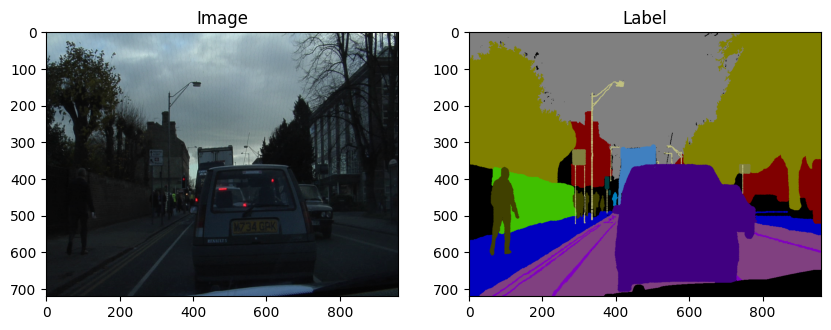

In [53]:
img_example = Image.open(os.path.join(train_dir, train_files[0]))
label_example = Image.open(os.path.join(train_labels_dir, train_labels_files[0]))

# Show the images

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_example)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(label_example)
plt.title('Label')

plt.show()

del(img_example, label_example)

Image tensor shape: torch.Size([8, 3, 360, 480]), <class 'torch.Tensor'>
Label tensor shape: torch.Size([8, 360, 480]), <class 'torch.Tensor'>


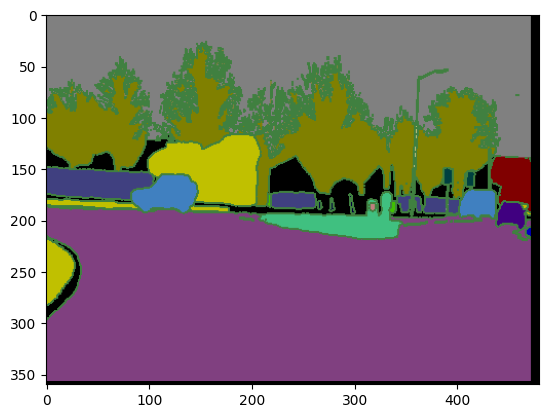

In [54]:
# Load class dictionary
class_dict: pd.DataFrame = pd.read_csv(class_dict_path)

# Create conversion dictionaries
rgb_to_label_dict: dict[tuple, int] = {
    (row['r'], row['g'], row['b']): idx
    for idx, row in class_dict.iterrows()
}

label_to_rgb_dict: dict[int, tuple] = {
    idx: (row['r'], row['g'], row['b'])
    for idx, row in class_dict.iterrows()
}

def rgb_to_label(image: torch.Tensor) -> torch.Tensor:
    width, height, _ = image.shape
    label_image = torch.zeros(width, height, device=device)

    # Transformar para inteiro, se necessário, para garantir comparação correta
    image = (image * 255).int()

    for rgb, label in rgb_to_label_dict.items():
        rgb_tensor = torch.tensor(rgb, device=device)
        mask = torch.all(image == rgb_tensor, dim=-1)
        label_image[mask] = label
        
    return label_image

def label_to_rgb_tensor(label_tensor: torch.Tensor) -> torch.Tensor:
    height, width = label_tensor.shape
    rgb_image = torch.zeros(3, height, width, dtype=torch.uint8)

    for label, rgb in label_to_rgb_dict.items():
        mask = (label_tensor == label)
        rgb_image[0][mask] = rgb[0]  # Red
        rgb_image[1][mask] = rgb[1]  # Green
        rgb_image[2][mask] = rgb[2]  # Blue

    return rgb_image

def read_image(image_path: str) -> torch.Tensor:
    image = Image.open(image_path)
    image = transforms.ToTensor()(image)
    return image

class CamVidDataset(Dataset):
    def __init__(self, img_dir: str, label_dir: str, augment: bool = False):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.augment = augment
        self.transform = transforms.Compose([
            transforms.Resize((360, 480)),
        ])
        self.img_files = os.listdir(img_dir)
        self.label_files = os.listdir(label_dir)

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        label_file = img_file.replace(".png", "_L.png")  # Supondo que o sufixo das máscaras seja '_L'

        img_path = os.path.join(self.img_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)

        img = read_image(img_path).to(device)
        label = read_image(label_path).to(device)

        img = self.transform(img)
        label = self.transform(label)
        
        if self.augment:
            # Apply the same random transformations to both image and label
            if torch.rand(1) > 0.5:
                img = transf_F.hflip(img)
                label = transf_F.hflip(label)
            
            # Pad the image and label with the same padding value (using a tuple)
            img = transf_F.pad(img, (10, 10, 10, 10))  # padding on all sides
            label = transf_F.pad(label, (10, 10, 10, 10))  # padding on all sides
        

            # Apply the same cropping to both image and label
            i, j, h, w = transforms.RandomCrop.get_params(img, output_size=(360, 480))
            img = transf_F.crop(img, i, j, h, w)
            label = transf_F.crop(label, i, j, h, w)
            
            # Color jitter only applies to the image
            img = transforms.ColorJitter(brightness=0.1, contrast=0, saturation=0, hue=0.2)(img)
        
        
        label = rgb_to_label(label.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)

        return img, label.long()

train_dataset = CamVidDataset(train_dir, train_labels_dir, augment=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

img, label = next(iter(train_loader))
print(f'Image tensor shape: {img.shape}, {type(img)}')
print(f'Label tensor shape: {label.shape}, {type(label)}')


rgb_tens = label_to_rgb_tensor(label[0])
rgb_image = Image.fromarray(rgb_tens.permute(1, 2, 0).numpy())
plt.imshow(rgb_image)
plt.show()

del(train_dataset, train_loader, img, label)          


In [55]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=32, depth=5):
        super(UNet, self).__init__()
        self.depth = depth  # Variable depth
        self.down_convs = nn.ModuleList()  # Encoder layers
        self.up_convs = nn.ModuleList()  # Decoder layers
        self.trans_convs = nn.ModuleList()  # Transposed convolutions (upsampling)
        i = 3 # Initial exponent of channel size

        # Encoder (Contracting Path)
        for d in range(depth):
            input_channels = in_channels if d == 0 else 2**(i + d - 1)
            output_channels = 2**(i + d)
            self.down_convs.append(self.conv_block(input_channels, output_channels))

        # Bottleneck
        self.bottleneck = self.conv_block(2**(i + depth - 1), 2**(i + depth))

        # Decoder (Expanding Path)
        for d in range(depth, 0, -1):
            input_channels = 2**(i + d)
            output_channels = 2**(i + d - 1)
            self.trans_convs.append(nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2))
            self.up_convs.append(self.conv_block(input_channels, output_channels))

        # Output layer
        self.out_conv = nn.Conv2d(2**i, num_classes, kernel_size=1)

    def forward(self, x):
        enc_outputs = []  # To store outputs from each encoder layer

        # Encoder
        for enc in self.down_convs:
            x = enc(x)
            enc_outputs.append(x)
            x = F.max_pool2d(x, 2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for idx in range(self.depth):
            x = self.trans_convs[idx](x)
            x = self.crop_and_concat(x, enc_outputs[-(idx+1)])
            x = self.up_convs[idx](x)

        # Ensure the final output has the same size as input
        if x.size(2) != enc_outputs[0].size(2):
            x = F.interpolate(x, size=(enc_outputs[0].size(2), enc_outputs[0].size(3)), mode='bilinear', align_corners=False)


        return self.out_conv(x)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop_and_concat(self, upsampled, bypass):
        crop_h = (bypass.size(2) - upsampled.size(2)) // 2
        crop_w = (bypass.size(3) - upsampled.size(3)) // 2
        bypass = bypass[:, :, crop_h:crop_h + upsampled.size(2), crop_w:crop_w + upsampled.size(3)]
        return torch.cat((upsampled, bypass), dim=1)

In [56]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for images, labels in train_loader:
            images = images.to(device) # Send data to device
            labels = labels.to(device) # Send data to device

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate pixel-wise accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_pixels / total_pixels

        # Validation phase
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("="*100)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.4f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    model = model.to(device)
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        running_loss = 0.0
        correct_pixels = 0
        total_pixels = 0

        for images, labels in train_loader:
            images = images.to(device) # Send data to device
            labels = labels.to(device) # Send data to device

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate pixel-wise accuracy
            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()

        train_loss = running_loss / len(train_loader)
        train_acc = correct_pixels / total_pixels

        # Validation phase
        model.eval()
        val_loss, val_acc = validate_model(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        end_time = time.time()
        epoch_time = end_time - start_time

        print("="*100)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.4f}s")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if (epoch + 1) % 10 == 0:  # For example, visualize every 5 epochs
            visualize_segmentation(model, val_loader, device)

    return model, history


def validate_model(model, val_loader, criterion, device='cuda'):
    model.eval()
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += labels.numel()
            
    val_loss = running_loss / len(val_loader)
    val_acc = correct_pixels / total_pixels

    return val_loss, val_acc

def visualize_segmentation(model, val_loader, device):
    model.eval()
    batch_idx = random.randint(0, len(val_loader) - 1)
    images, labels = list(val_loader)[batch_idx]
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

    img_idx = random.randint(0, len(images) - 1)
    img = images[img_idx].cpu().numpy().transpose(1, 2, 0)
    label = labels[img_idx].cpu().numpy()
    pred = preds[img_idx].cpu().numpy()
    pred_rgb = label_to_rgb_tensor(pred).cpu().numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    
    axes[1].imshow(label_to_rgb_tensor(label).permute(1, 2, 0).cpu().numpy())
    axes[1].set_title('Ground Truth')

    axes[2].imshow(pred_rgb)
    axes[2].set_title('Predicted Mask')

    plt.show()

In [57]:
# Dataset and DataLoader
train_dataset = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir)
val_dataset = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)

In [58]:
# Model, criterion, optimizer
model = UNet(in_channels=3, num_classes=32, depth=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Epoch [1/100] - Time: 29.3492s
Train Loss: 2.6968, Train Acc: 0.4197
Val Loss: 2.5262, Val Acc: 0.4678
Epoch [2/100] - Time: 28.5661s
Train Loss: 1.9188, Train Acc: 0.6674
Val Loss: 1.7636, Val Acc: 0.6640
Epoch [3/100] - Time: 29.0383s
Train Loss: 1.4557, Train Acc: 0.7117
Val Loss: 1.3599, Val Acc: 0.6952
Epoch [4/100] - Time: 28.8929s
Train Loss: 1.2017, Train Acc: 0.7322
Val Loss: 1.2154, Val Acc: 0.7282
Epoch [5/100] - Time: 28.7668s
Train Loss: 1.0639, Train Acc: 0.7470
Val Loss: 1.0243, Val Acc: 0.7509
Epoch [6/100] - Time: 28.6442s
Train Loss: 0.9934, Train Acc: 0.7513
Val Loss: 1.0800, Val Acc: 0.7222
Epoch [7/100] - Time: 28.8154s
Train Loss: 0.9206, Train Acc: 0.7617
Val Loss: 0.9375, Val Acc: 0.7591
Epoch [8/100] - Time: 29.2495s
Train Loss: 0.8899, Train Acc: 0.7603
Val Loss: 0.8987, Val Acc: 0.7552
Epoch [9/100] - Time: 28.9102s
Train Loss: 0.8544, Train Acc: 0.7659
Val Loss: 0.9328, Val Acc: 0.7392
Epoch [10/100] - Time: 28.9252s
Train Loss: 0.8325, Train Acc: 0.7777
Val

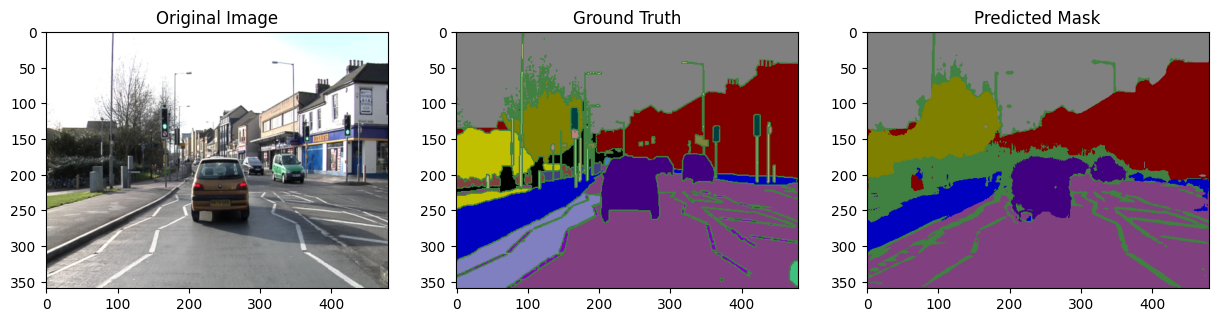

Epoch [11/100] - Time: 28.8310s
Train Loss: 0.8165, Train Acc: 0.7803
Val Loss: 0.9281, Val Acc: 0.7493
Epoch [12/100] - Time: 28.6498s
Train Loss: 0.7889, Train Acc: 0.7873
Val Loss: 0.8538, Val Acc: 0.7629
Epoch [13/100] - Time: 29.0595s
Train Loss: 0.7514, Train Acc: 0.7952
Val Loss: 0.8221, Val Acc: 0.7723
Epoch [14/100] - Time: 29.5766s
Train Loss: 0.7345, Train Acc: 0.7964
Val Loss: 0.7817, Val Acc: 0.7831
Epoch [15/100] - Time: 28.7936s
Train Loss: 0.7235, Train Acc: 0.7958
Val Loss: 0.8254, Val Acc: 0.7781
Epoch [16/100] - Time: 28.3441s
Train Loss: 0.6990, Train Acc: 0.8026
Val Loss: 0.7409, Val Acc: 0.7937
Epoch [17/100] - Time: 29.2127s
Train Loss: 0.6824, Train Acc: 0.8061
Val Loss: 0.7388, Val Acc: 0.7939
Epoch [18/100] - Time: 29.2642s
Train Loss: 0.6544, Train Acc: 0.8123
Val Loss: 0.7744, Val Acc: 0.7781
Epoch [19/100] - Time: 28.5893s
Train Loss: 0.6400, Train Acc: 0.8169
Val Loss: 0.6682, Val Acc: 0.8108
Epoch [20/100] - Time: 28.6994s
Train Loss: 0.6381, Train Acc: 0

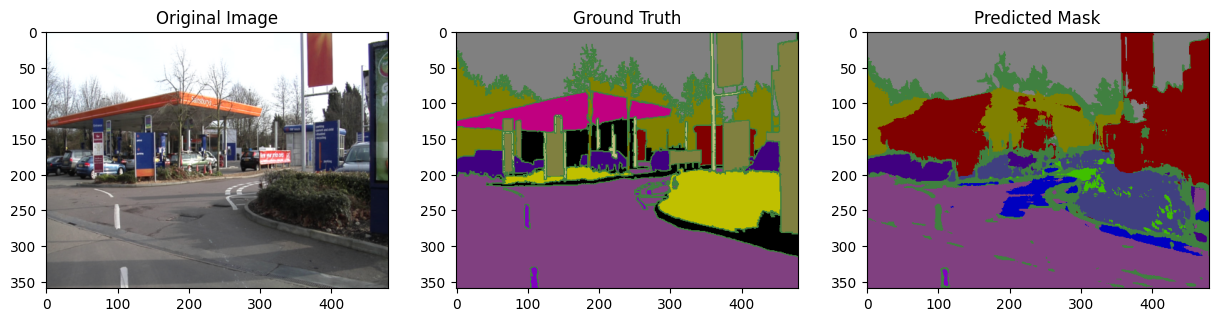

Epoch [21/100] - Time: 28.3821s
Train Loss: 0.6121, Train Acc: 0.8235
Val Loss: 0.6898, Val Acc: 0.8063
Epoch [22/100] - Time: 28.5052s
Train Loss: 0.6051, Train Acc: 0.8249
Val Loss: 0.6735, Val Acc: 0.8089
Epoch [23/100] - Time: 28.6414s
Train Loss: 0.5998, Train Acc: 0.8271
Val Loss: 0.7468, Val Acc: 0.7900
Epoch [24/100] - Time: 28.3901s
Train Loss: 0.6044, Train Acc: 0.8235
Val Loss: 0.6551, Val Acc: 0.8164
Epoch [25/100] - Time: 28.2245s
Train Loss: 0.5659, Train Acc: 0.8328
Val Loss: 0.6211, Val Acc: 0.8231
Epoch [26/100] - Time: 28.6132s
Train Loss: 0.5704, Train Acc: 0.8326
Val Loss: 0.6553, Val Acc: 0.8167
Epoch [27/100] - Time: 28.4842s
Train Loss: 0.5598, Train Acc: 0.8340
Val Loss: 0.6193, Val Acc: 0.8246
Epoch [28/100] - Time: 28.3605s
Train Loss: 0.5462, Train Acc: 0.8367
Val Loss: 0.7209, Val Acc: 0.7948
Epoch [29/100] - Time: 28.3469s
Train Loss: 0.5445, Train Acc: 0.8361
Val Loss: 0.7047, Val Acc: 0.8012
Epoch [30/100] - Time: 28.5973s
Train Loss: 0.5491, Train Acc: 0

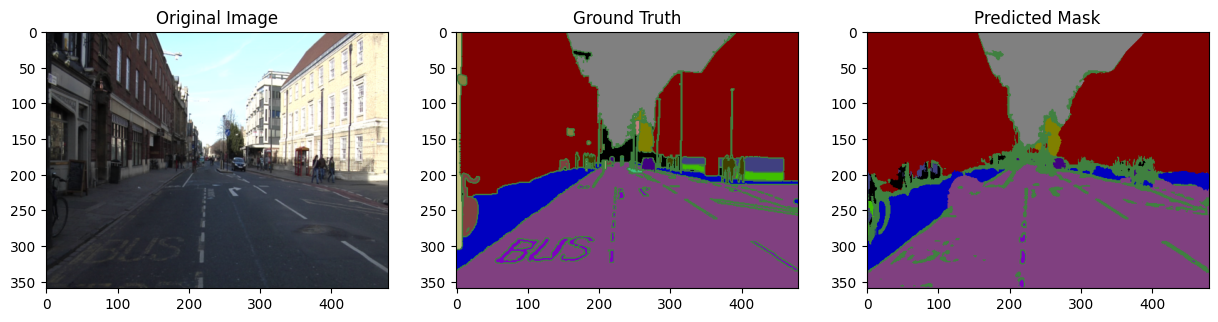

Epoch [31/100] - Time: 28.8062s
Train Loss: 0.5227, Train Acc: 0.8417
Val Loss: 0.6044, Val Acc: 0.8236
Epoch [32/100] - Time: 28.5663s
Train Loss: 0.5100, Train Acc: 0.8447
Val Loss: 0.5772, Val Acc: 0.8328
Epoch [33/100] - Time: 28.3775s
Train Loss: 0.5097, Train Acc: 0.8453
Val Loss: 0.6141, Val Acc: 0.8200
Epoch [34/100] - Time: 28.7364s
Train Loss: 0.5012, Train Acc: 0.8462
Val Loss: 0.6394, Val Acc: 0.8148
Epoch [35/100] - Time: 28.6451s
Train Loss: 0.5016, Train Acc: 0.8458
Val Loss: 0.6100, Val Acc: 0.8251
Epoch [36/100] - Time: 28.7439s
Train Loss: 0.5066, Train Acc: 0.8453
Val Loss: 0.6144, Val Acc: 0.8266
Epoch [37/100] - Time: 28.5783s
Train Loss: 0.4996, Train Acc: 0.8456
Val Loss: 0.5975, Val Acc: 0.8294
Epoch [38/100] - Time: 28.9097s
Train Loss: 0.4855, Train Acc: 0.8497
Val Loss: 0.6108, Val Acc: 0.8218
Epoch [39/100] - Time: 28.5892s
Train Loss: 0.4753, Train Acc: 0.8522
Val Loss: 0.5909, Val Acc: 0.8289
Epoch [40/100] - Time: 28.5645s
Train Loss: 0.4678, Train Acc: 0

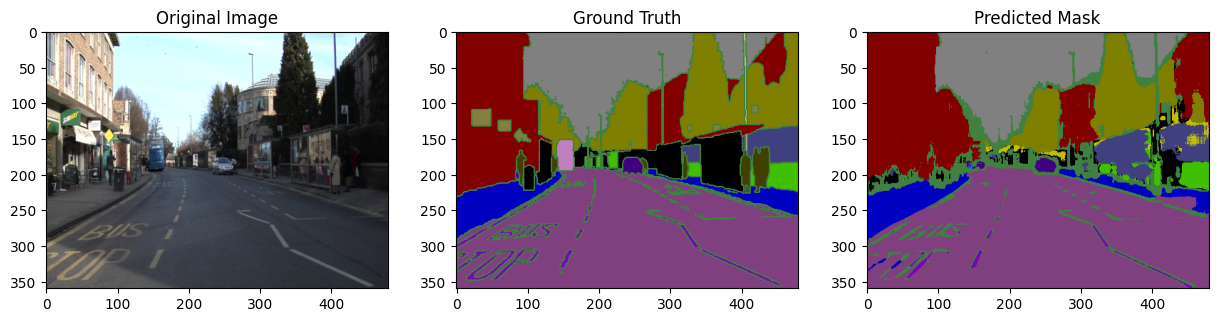

Epoch [41/100] - Time: 28.7237s
Train Loss: 0.4626, Train Acc: 0.8564
Val Loss: 0.5755, Val Acc: 0.8330
Epoch [42/100] - Time: 28.4890s
Train Loss: 0.4775, Train Acc: 0.8520
Val Loss: 0.6403, Val Acc: 0.8175
Epoch [43/100] - Time: 28.9764s
Train Loss: 0.4762, Train Acc: 0.8520
Val Loss: 0.5669, Val Acc: 0.8369
Epoch [44/100] - Time: 28.6245s
Train Loss: 0.4504, Train Acc: 0.8587
Val Loss: 0.5570, Val Acc: 0.8402
Epoch [45/100] - Time: 28.6594s
Train Loss: 0.4316, Train Acc: 0.8636
Val Loss: 0.5539, Val Acc: 0.8400
Epoch [46/100] - Time: 28.5545s
Train Loss: 0.4256, Train Acc: 0.8656
Val Loss: 0.5448, Val Acc: 0.8437
Epoch [47/100] - Time: 28.4704s
Train Loss: 0.4211, Train Acc: 0.8662
Val Loss: 0.5547, Val Acc: 0.8402
Epoch [48/100] - Time: 28.6827s
Train Loss: 0.4244, Train Acc: 0.8661
Val Loss: 0.5880, Val Acc: 0.8282
Epoch [49/100] - Time: 28.5199s
Train Loss: 0.4163, Train Acc: 0.8683
Val Loss: 0.5777, Val Acc: 0.8308
Epoch [50/100] - Time: 28.5676s
Train Loss: 0.4322, Train Acc: 0

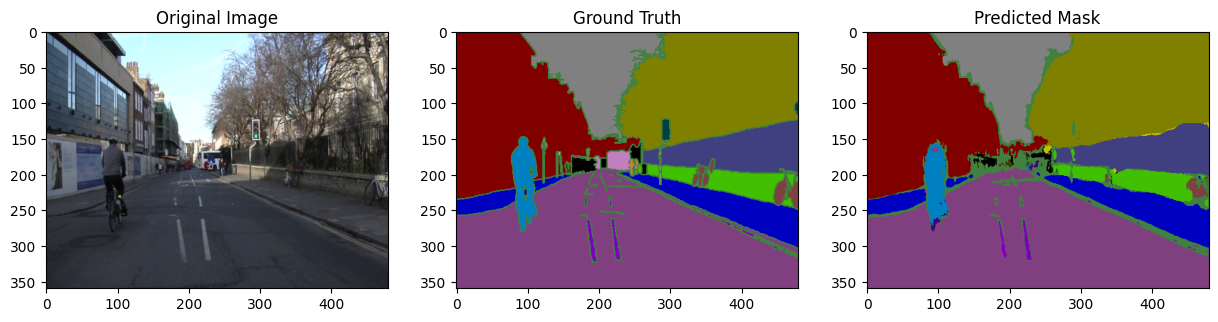

Epoch [51/100] - Time: 28.6510s
Train Loss: 0.4349, Train Acc: 0.8643
Val Loss: 0.5922, Val Acc: 0.8286
Epoch [52/100] - Time: 29.0089s
Train Loss: 0.4678, Train Acc: 0.8544
Val Loss: 0.5530, Val Acc: 0.8391
Epoch [53/100] - Time: 28.7735s
Train Loss: 0.4143, Train Acc: 0.8688
Val Loss: 0.5682, Val Acc: 0.8401
Epoch [54/100] - Time: 28.6820s
Train Loss: 0.3909, Train Acc: 0.8745
Val Loss: 0.5551, Val Acc: 0.8413
Epoch [55/100] - Time: 28.5153s
Train Loss: 0.3868, Train Acc: 0.8772
Val Loss: 0.5522, Val Acc: 0.8458
Epoch [56/100] - Time: 29.0828s
Train Loss: 0.3957, Train Acc: 0.8741
Val Loss: 0.5708, Val Acc: 0.8368
Epoch [57/100] - Time: 28.4663s
Train Loss: 0.3828, Train Acc: 0.8771
Val Loss: 0.5570, Val Acc: 0.8413
Epoch [58/100] - Time: 28.6091s
Train Loss: 0.3763, Train Acc: 0.8791
Val Loss: 0.5589, Val Acc: 0.8462
Epoch [59/100] - Time: 28.5768s
Train Loss: 0.3699, Train Acc: 0.8808
Val Loss: 0.5502, Val Acc: 0.8462
Epoch [60/100] - Time: 28.5012s
Train Loss: 0.3708, Train Acc: 0

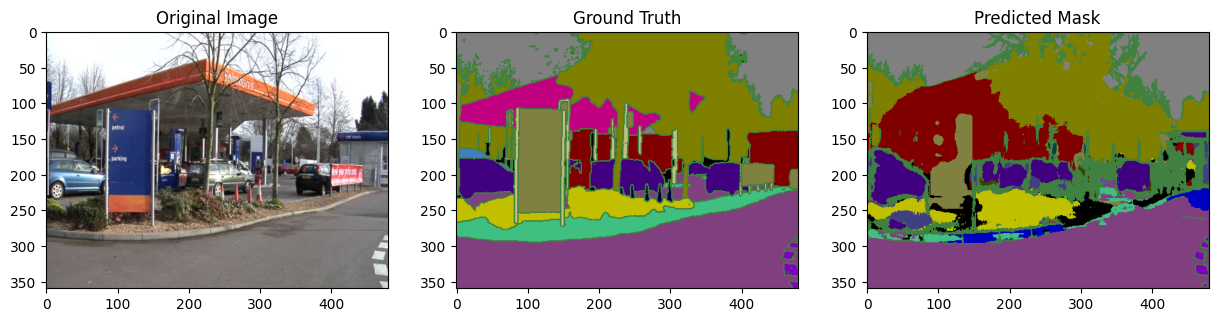

Epoch [61/100] - Time: 28.3209s
Train Loss: 0.3640, Train Acc: 0.8841
Val Loss: 0.5693, Val Acc: 0.8401
Epoch [62/100] - Time: 28.9267s
Train Loss: 0.3849, Train Acc: 0.8776
Val Loss: 0.5538, Val Acc: 0.8419
Epoch [63/100] - Time: 28.6194s
Train Loss: 0.3536, Train Acc: 0.8860
Val Loss: 0.5306, Val Acc: 0.8472
Epoch [64/100] - Time: 28.7996s
Train Loss: 0.3471, Train Acc: 0.8876
Val Loss: 0.5483, Val Acc: 0.8435
Epoch [65/100] - Time: 29.1312s
Train Loss: 0.3418, Train Acc: 0.8884
Val Loss: 0.5360, Val Acc: 0.8524
Epoch [66/100] - Time: 28.6552s
Train Loss: 0.3443, Train Acc: 0.8884
Val Loss: 0.5582, Val Acc: 0.8420
Epoch [67/100] - Time: 28.7088s
Train Loss: 0.3571, Train Acc: 0.8841
Val Loss: 0.5453, Val Acc: 0.8487
Epoch [68/100] - Time: 28.2830s
Train Loss: 0.3278, Train Acc: 0.8925
Val Loss: 0.5369, Val Acc: 0.8485
Epoch [69/100] - Time: 28.5352s
Train Loss: 0.3346, Train Acc: 0.8912
Val Loss: 0.5548, Val Acc: 0.8453
Epoch [70/100] - Time: 28.4533s
Train Loss: 0.3897, Train Acc: 0

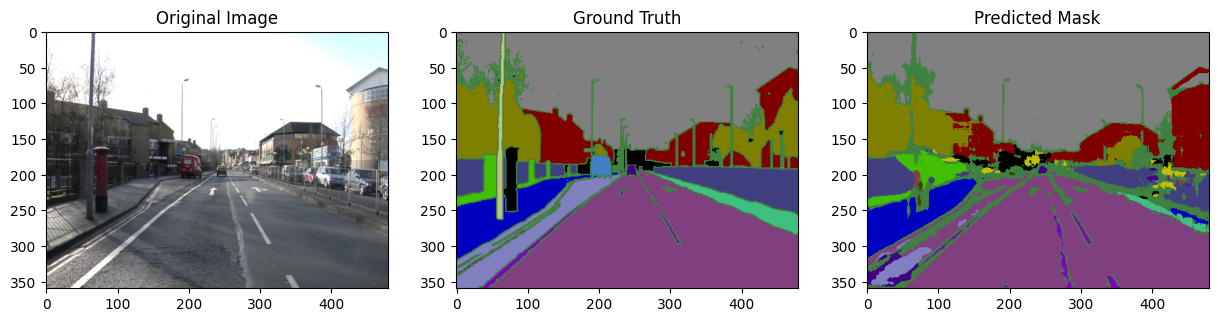

Epoch [71/100] - Time: 28.7142s
Train Loss: 0.3612, Train Acc: 0.8832
Val Loss: 0.5949, Val Acc: 0.8364
Epoch [72/100] - Time: 28.3972s
Train Loss: 0.3454, Train Acc: 0.8895
Val Loss: 0.5733, Val Acc: 0.8434
Epoch [73/100] - Time: 29.1261s
Train Loss: 0.4430, Train Acc: 0.8626
Val Loss: 0.5527, Val Acc: 0.8408
Epoch [74/100] - Time: 28.6304s
Train Loss: 0.3370, Train Acc: 0.8896
Val Loss: 0.5278, Val Acc: 0.8494
Epoch [75/100] - Time: 28.5802s
Train Loss: 0.3138, Train Acc: 0.8966
Val Loss: 0.5427, Val Acc: 0.8498
Epoch [76/100] - Time: 28.4875s
Train Loss: 0.3116, Train Acc: 0.8967
Val Loss: 0.5399, Val Acc: 0.8515
Epoch [77/100] - Time: 28.6338s
Train Loss: 0.3130, Train Acc: 0.8964
Val Loss: 0.5311, Val Acc: 0.8547
Epoch [78/100] - Time: 29.0506s
Train Loss: 0.3009, Train Acc: 0.8999
Val Loss: 0.5370, Val Acc: 0.8533
Epoch [79/100] - Time: 28.5478s
Train Loss: 0.2937, Train Acc: 0.9018
Val Loss: 0.5455, Val Acc: 0.8531
Epoch [80/100] - Time: 28.3518s
Train Loss: 0.2960, Train Acc: 0

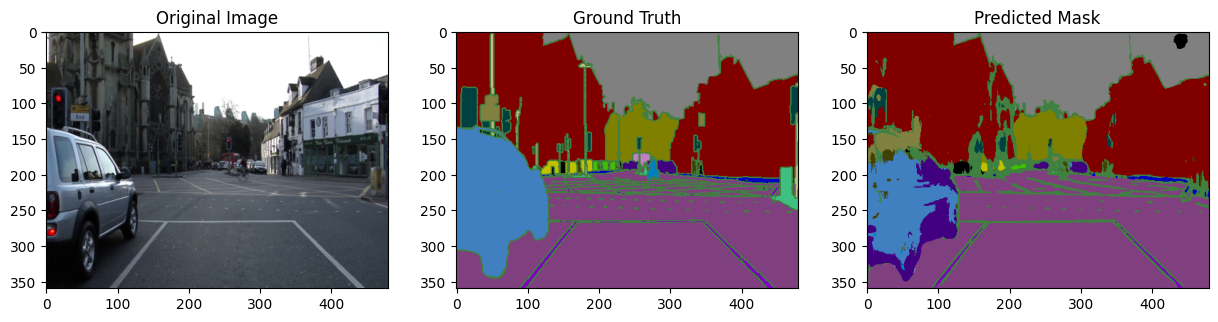

Epoch [81/100] - Time: 29.1371s
Train Loss: 0.2979, Train Acc: 0.9012
Val Loss: 0.5457, Val Acc: 0.8544
Epoch [82/100] - Time: 28.7981s
Train Loss: 0.2950, Train Acc: 0.9013
Val Loss: 0.5308, Val Acc: 0.8557
Epoch [83/100] - Time: 29.5526s
Train Loss: 0.2888, Train Acc: 0.9035
Val Loss: 0.5572, Val Acc: 0.8509
Epoch [84/100] - Time: 28.8862s
Train Loss: 0.2903, Train Acc: 0.9028
Val Loss: 0.5564, Val Acc: 0.8526
Epoch [85/100] - Time: 28.7200s
Train Loss: 0.2852, Train Acc: 0.9048
Val Loss: 0.5352, Val Acc: 0.8543
Epoch [86/100] - Time: 28.8732s
Train Loss: 0.2770, Train Acc: 0.9063
Val Loss: 0.5514, Val Acc: 0.8518
Epoch [87/100] - Time: 28.8141s
Train Loss: 0.2830, Train Acc: 0.9052
Val Loss: 0.5553, Val Acc: 0.8541
Epoch [88/100] - Time: 28.7509s
Train Loss: 0.2795, Train Acc: 0.9054
Val Loss: 0.5791, Val Acc: 0.8477
Epoch [89/100] - Time: 29.1186s
Train Loss: 0.2743, Train Acc: 0.9070
Val Loss: 0.5561, Val Acc: 0.8564
Epoch [90/100] - Time: 28.9818s
Train Loss: 0.2889, Train Acc: 0

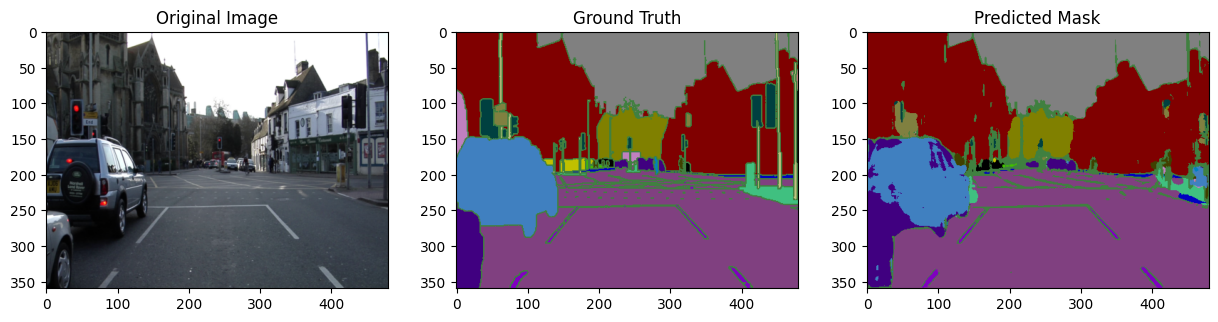

Epoch [91/100] - Time: 28.5390s
Train Loss: 0.2761, Train Acc: 0.9065
Val Loss: 0.5445, Val Acc: 0.8533
Epoch [92/100] - Time: 28.7083s
Train Loss: 0.2697, Train Acc: 0.9087
Val Loss: 0.5473, Val Acc: 0.8550
Epoch [93/100] - Time: 28.5811s
Train Loss: 0.2986, Train Acc: 0.9081
Val Loss: 0.7678, Val Acc: 0.8019
Epoch [94/100] - Time: 28.8021s
Train Loss: 0.4951, Train Acc: 0.8522
Val Loss: 0.5786, Val Acc: 0.8396
Epoch [95/100] - Time: 28.4367s
Train Loss: 0.3538, Train Acc: 0.8843
Val Loss: 0.5288, Val Acc: 0.8531
Epoch [96/100] - Time: 28.5673s
Train Loss: 0.2803, Train Acc: 0.9057
Val Loss: 0.5158, Val Acc: 0.8600
Epoch [97/100] - Time: 29.5078s
Train Loss: 0.2737, Train Acc: 0.9087
Val Loss: 0.5756, Val Acc: 0.8486
Epoch [98/100] - Time: 28.6035s
Train Loss: 0.3078, Train Acc: 0.8975
Val Loss: 0.5250, Val Acc: 0.8580
Epoch [99/100] - Time: 28.6637s
Train Loss: 0.2649, Train Acc: 0.9102
Val Loss: 0.5280, Val Acc: 0.8590
Epoch [100/100] - Time: 28.5906s
Train Loss: 0.2592, Train Acc: 

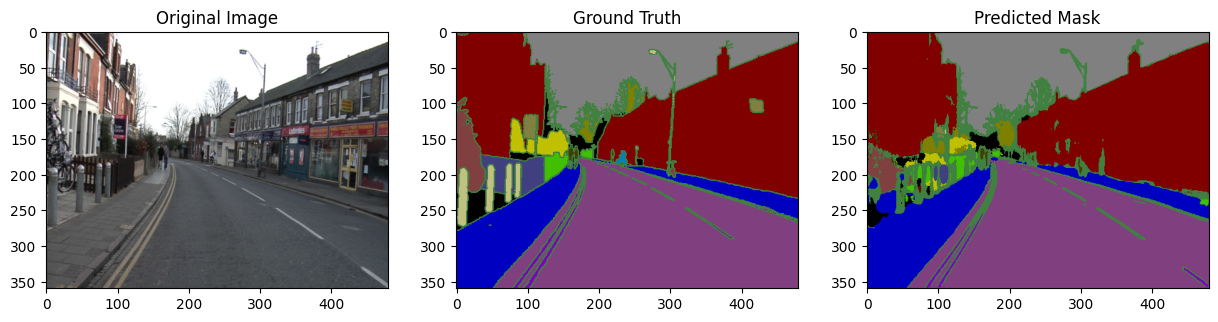

In [59]:
# Train and validate the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100, device='cuda')

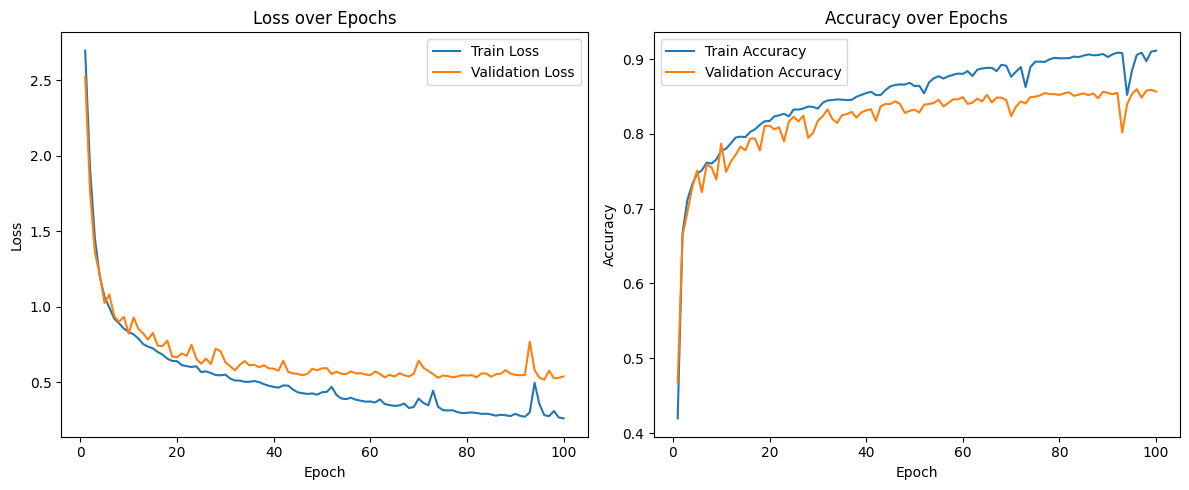

In [60]:
def plot_metrics(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(history)


In [61]:
# Create datasets with augmentation applied only to the training set
train_dataset_aug = CamVidDataset(img_dir=train_dir, label_dir=train_labels_dir, augment=True)
val_dataset_aug = CamVidDataset(img_dir=val_dir, label_dir=val_labels_dir, augment=True)

train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=4, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_dataset_aug, batch_size=4, shuffle=True)

# Model, criterion, optimizer (no augmentation)
model_aug = UNet(in_channels=3, num_classes=32, depth=5)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#summary(model, (3, 360, 480))


In [62]:
model_aug, history_aug = train_model(
    model_aug,
    train_loader_aug,
    val_loader_aug,
    criterion,
    optimizer,
    num_epochs = 3,
    device = 'cuda',
)

Epoch [1/3] - Time: 29.5211s
Train Loss: 3.5426, Train Acc: 0.0078
Val Loss: 3.5449, Val Acc: 0.0069
Epoch [2/3] - Time: 29.5416s
Train Loss: 3.5431, Train Acc: 0.0077
Val Loss: 3.5468, Val Acc: 0.0069
Epoch [3/3] - Time: 29.5032s
Train Loss: 3.5425, Train Acc: 0.0078
Val Loss: 3.5481, Val Acc: 0.0067


## Testing the model

In [63]:
def evaluate_model(model, test_loader, device='cuda'):
    model = model.to(device)  # Move the model to the correct device (GPU or CPU)
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for img, label in test_loader:
            img = img.to(device)  # Move the image to the correct device (GPU or CPU)
            label = label.to(device)  # Move the label to the correct device (GPU or CPU)
            
            # Forward pass
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
            
            all_preds.append(preds.cpu())  # Move predictions to CPU to store them
            all_labels.append(label.cpu())  # Move labels to CPU to store them
    
    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    return all_preds, all_labels


In [64]:
# Define the test dataset and DataLoader
test_dataset = CamVidDataset(img_dir=test_dir, label_dir=test_labels_dir, augment=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Evaluate the model
test_preds, test_labels = evaluate_model(model, test_loader, device='cuda')

In [65]:
from sklearn.metrics import precision_score, recall_score, f1_score
 
def compute_accuracy(preds, labels):
    correct = (preds == labels).sum().item()
    total = labels.numel()
    accuracy = correct / total
    return accuracy

def compute_iou(preds, labels, num_classes):
    iou_list = []
    for i in range(num_classes):
        pred_i = (preds == i)
        label_i = (labels == i)
        intersection = (pred_i & label_i).sum().item()
        union = (pred_i | label_i).sum().item()
        iou = intersection / union if union != 0 else 0
        iou_list.append(iou)
    return np.mean(iou_list)

def compute_precision_recall_f1(preds, labels, num_classes):
    preds = preds.numpy()
    labels = labels.numpy()
    
    precision = precision_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    recall = recall_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    f1 = f1_score(labels.flatten(), preds.flatten(), average='weighted', zero_division=0)
    
    return precision, recall, f1

# Compute accuracy
accuracy = compute_accuracy(test_preds, test_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Compute IoU
num_classes = 32  # number of classes in the dataset
iou = compute_iou(test_preds, test_labels, num_classes)
print(f'Mean IoU: {iou:.4f}')

# Compute Precision, Recall, F1-Score
precision, recall, f1 = compute_precision_recall_f1(test_preds, test_labels, num_classes)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Test Accuracy: 82.10%
Mean IoU: 0.2890
Precision: 0.8210
Recall: 0.8210
F1-Score: 0.8168


In [66]:
# Initialize global semantic space
global_semantic_space = torch.zeros((32, 128), device=device)
num_samples_per_class = torch.zeros(32, device=device)

# Function to update global semantic space
def update_global_semantic_space(embeddings, labels, global_semantic_space, num_samples_per_class):
    B, C, H, W = embeddings.size()
    embeddings_flat = embeddings.permute(0, 2, 3, 1).reshape(B * H * W, C)
    labels_flat = labels.view(B * H * W)

    for class_id in range(32):
        mask = (labels_flat == class_id)
        if mask.sum() > 0:
            class_embeddings = embeddings_flat[mask]
            global_semantic_space[class_id] += class_embeddings.sum(dim=0)
            num_samples_per_class[class_id] += mask.sum()

    for class_id in range(32):
        if num_samples_per_class[class_id] > 0:
            global_semantic_space[class_id] /= num_samples_per_class[class_id]
    global_semantic_space = F.normalize(global_semantic_space, dim=1)
    
    return global_semantic_space


In [67]:
class FeatureExtractorUNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=32, embedding_dim=128, depth=5):
        super(FeatureExtractorUNet, self).__init__()
        self.depth = depth
        self.down_convs = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        self.trans_convs = nn.ModuleList()
        self.embedding_dim = embedding_dim

        i = 3  # Initial exponent of channel size

        # Encoder (Contracting Path)
        for d in range(depth):
            input_channels = in_channels if d == 0 else 2**(i + d - 1)
            output_channels = 2**(i + d)
            self.down_convs.append(self.conv_block(input_channels, output_channels))

        # Bottleneck
        self.bottleneck = self.conv_block(2**(i + depth - 1), 2**(i + depth))

        # Decoder (Expanding Path)
        for d in range(depth, 0, -1):
            input_channels = 2**(i + d)
            output_channels = 2**(i + d - 1)
            self.trans_convs.append(nn.ConvTranspose2d(input_channels, output_channels, kernel_size=2, stride=2))
            self.up_convs.append(self.conv_block(input_channels, output_channels))

        # Embedding layer: Reduce the number of channels to 128 for contrastive learning
        self.embedding_layer = nn.Conv2d(2**i, embedding_dim, kernel_size=1)

        # Output layer for segmentation
        self.out_conv = nn.Conv2d(2**i, num_classes, kernel_size=1)

    def forward(self, x, extract_embeddings=False):
        enc_outputs = []  # To store outputs from each encoder layer

        # Encoder
        for enc in self.down_convs:
            x = enc(x)
            enc_outputs.append(x)
            x = F.max_pool2d(x, 2)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder
        for idx in range(self.depth):
            x = self.trans_convs[idx](x)
            x = self.crop_and_concat(x, enc_outputs[-(idx+1)])
            x = self.up_convs[idx](x)

        # Resize the output if necessary
        if x.size(2) != enc_outputs[0].size(2):
            x = F.interpolate(x, size=(enc_outputs[0].size(2), enc_outputs[0].size(3)), mode='bilinear', align_corners=False)

        # If `extract_embeddings` is True, return the embeddings
        if extract_embeddings:
            embeddings = self.embedding_layer(x)
            embeddings = F.normalize(embeddings, p=2, dim=1)  # Normalize embeddings for contrastive loss
            return embeddings
        else:
            # Otherwise, return the segmentation output
            segmentation = self.out_conv(x)
            return segmentation

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )

    def crop_and_concat(self, upsampled, bypass):
        crop_h = (bypass.size(2) - upsampled.size(2)) // 2
        crop_w = (bypass.size(3) - upsampled.size(3)) // 2
        bypass = bypass[:, :, crop_h:crop_h + upsampled.size(2), crop_w:crop_w + upsampled.size(3)]
        return torch.cat((upsampled, bypass), dim=1)


In [68]:
class ModifiedCrossEntropyLoss(nn.Module):
    def __init__(self, num_classes=32, ignore_index=255):
        super(ModifiedCrossEntropyLoss, self).__init__()
        self.num_classes = num_classes
        self.ignore_index = ignore_index

    def forward(self, predictions, targets):
        return F.cross_entropy(predictions, targets, ignore_index=self.ignore_index)


In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super(PixelContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, local_embeddings, global_semantic_space, labels):
        """
        local_embeddings: Tensor of shape (N, D) where N = B*H*W and D = embedding_dim
        global_semantic_space: Tensor of shape (num_classes, D)
        labels: Tensor of shape (N,) with class indices
        """
        # Normalize embeddings
        local_embeddings = F.normalize(local_embeddings, p=2, dim=1)  # (N, D)
        global_semantic_space = F.normalize(global_semantic_space, p=2, dim=1)  # (C, D)

        # Select the positive embeddings based on labels
        selected_global_embeddings = global_semantic_space[labels]  # (N, D)

        # Compute cosine similarities between local embeddings and all global embeddings
        similarities = torch.matmul(local_embeddings, global_semantic_space.T)  # (N, C)

        # Scale similarities by temperature
        similarities = similarities / self.temperature  # (N, C)

        # Create labels for cross-entropy (each row's correct class is labels[i])
        ce_labels = labels  # (N,)

        # Compute cross-entropy loss where positives are the correct classes
        loss = F.cross_entropy(similarities, ce_labels)

        return loss


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/200], Total Loss: 355.5282, Contrastive Loss: 2.9398, CE/Focal Loss: 3.4424
Epoch [2/200], Total Loss: 350.1102, Contrastive Loss: 3.0115, CE/Focal Loss: 3.4138
Epoch [3/200], Total Loss: 345.3001, Contrastive Loss: 2.6844, CE/Focal Loss: 3.4246
Epoch [4/200], Total Loss: 341.5646, Contrastive Loss: 2.9021, CE/Focal Loss: 3.4102
Epoch [5/200], Total Loss: 338.3983, Contrastive Loss: 2.6535, CE/Focal Loss: 3.3639
Epoch [6/200], Total Loss: 335.8949, Contrastive Loss: 2.7142, CE/Focal Loss: 3.2916
Epoch [7/200], Total Loss: 333.6832, Contrastive Loss: 2.8220, CE/Focal Loss: 3.2761
Epoch [8/200], Total Loss: 331.7082, Contrastive Loss: 2.6327, CE/Focal Loss: 3.2481
Epoch [9/200], Total Loss: 329.8043, Contrastive Loss: 2.8405, CE/Focal Loss: 3.2268
Epoch [10/200], Total Loss: 327.8900, Contrastive Loss: 2.4122, CE/Focal Loss: 3.2830
Epoch [11/200], Total Loss: 325.9160, Contrastive Loss: 2.7451, CE/Focal Loss: 3.1946
Epoch [12/200], Total Loss: 324.2897, Contrastive Loss: 2.7459,

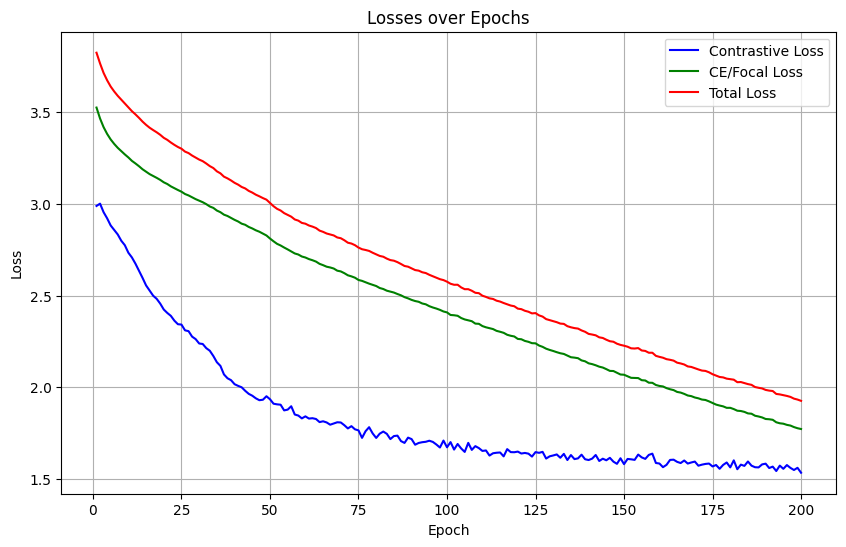

In [70]:
# Initialize the FeatureExtractorUNet model
model = FeatureExtractorUNet(in_channels=3, num_classes=32, embedding_dim=128, depth=5).to(device)

# Initialize optimizer (Adam in this case) and scheduler (you can adjust the learning rate scheduler if needed)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

# Define loss functions
contrastive_loss_fn = PixelContrastiveLoss(temperature=0.2)
modified_ce_loss_fn = ModifiedCrossEntropyLoss(num_classes=32)


num_epochs = 200
alpha = 0.1  # Lowered weight for contrastive loss
beta = 1.0   # Weight for cross-entropy/focal loss

import matplotlib.pyplot as plt

# Initialize lists to store loss values for plotting
contrastive_losses = []
ce_focal_losses = []
total_losses = []

# Start your training loop
for epoch in range(num_epochs):
    model.train()
    total_epoch_loss = 0
    total_contrastive_loss = 0
    total_ce_focal_loss = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Extract embeddings for contrastive learning
        embeddings = model(images, extract_embeddings=True)
        B, C, H, W = embeddings.size()
        
        # Resize labels to match the feature map size
        labels_resized = F.interpolate(labels.unsqueeze(1).float(), size=(H, W), mode='nearest').squeeze(1).long()
        embeddings_flat = embeddings.permute(0, 2, 3, 1).reshape(B * H * W, C)
        labels_flat = labels_resized.view(B * H * W)

        # Update the global semantic space before computing contrastive loss
        with torch.no_grad():
            for class_id in range(num_classes):
                mask = (labels_flat == class_id)
                if mask.sum() > 0:
                    global_semantic_space[class_id] += embeddings_flat[mask].sum(dim=0)
                    num_samples_per_class[class_id] += mask.sum()

        for class_id in range(num_classes):
            if num_samples_per_class[class_id] > 0:
                global_semantic_space[class_id] /= num_samples_per_class[class_id]

        global_semantic_space = F.normalize(global_semantic_space, dim=1)
        
        # Calculate contrastive loss and cross-entropy loss
        lcon = contrastive_loss_fn(embeddings_flat, global_semantic_space, labels_flat)
        
        # Perform segmentation (not embedding extraction)
        outputs = model(images, extract_embeddings=False)
        lce = modified_ce_loss_fn(outputs, labels_resized)
        
        # Combine losses with weights
        total_loss = alpha * lcon + beta * lce

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        total_epoch_loss += total_loss.item()
        total_contrastive_loss += lcon.item()
        total_ce_focal_loss += lce.item()
    
    # Store the average losses for this epoch
    total_losses.append(total_epoch_loss / len(train_loader))
    contrastive_losses.append(total_contrastive_loss / len(train_loader))
    ce_focal_losses.append(total_ce_focal_loss / len(train_loader))
    
    # Learning rate scheduler
    scheduler.step(total_epoch_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_epoch_loss:.4f}, Contrastive Loss: {lcon.item():.4f}, CE/Focal Loss: {lce.item():.4f}")

# Plotting the losses after training
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), contrastive_losses, label='Contrastive Loss', color='blue')
plt.plot(range(1, num_epochs + 1), ce_focal_losses, label='CE/Focal Loss', color='green')
plt.plot(range(1, num_epochs + 1), total_losses, label='Total Loss', color='red')

plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



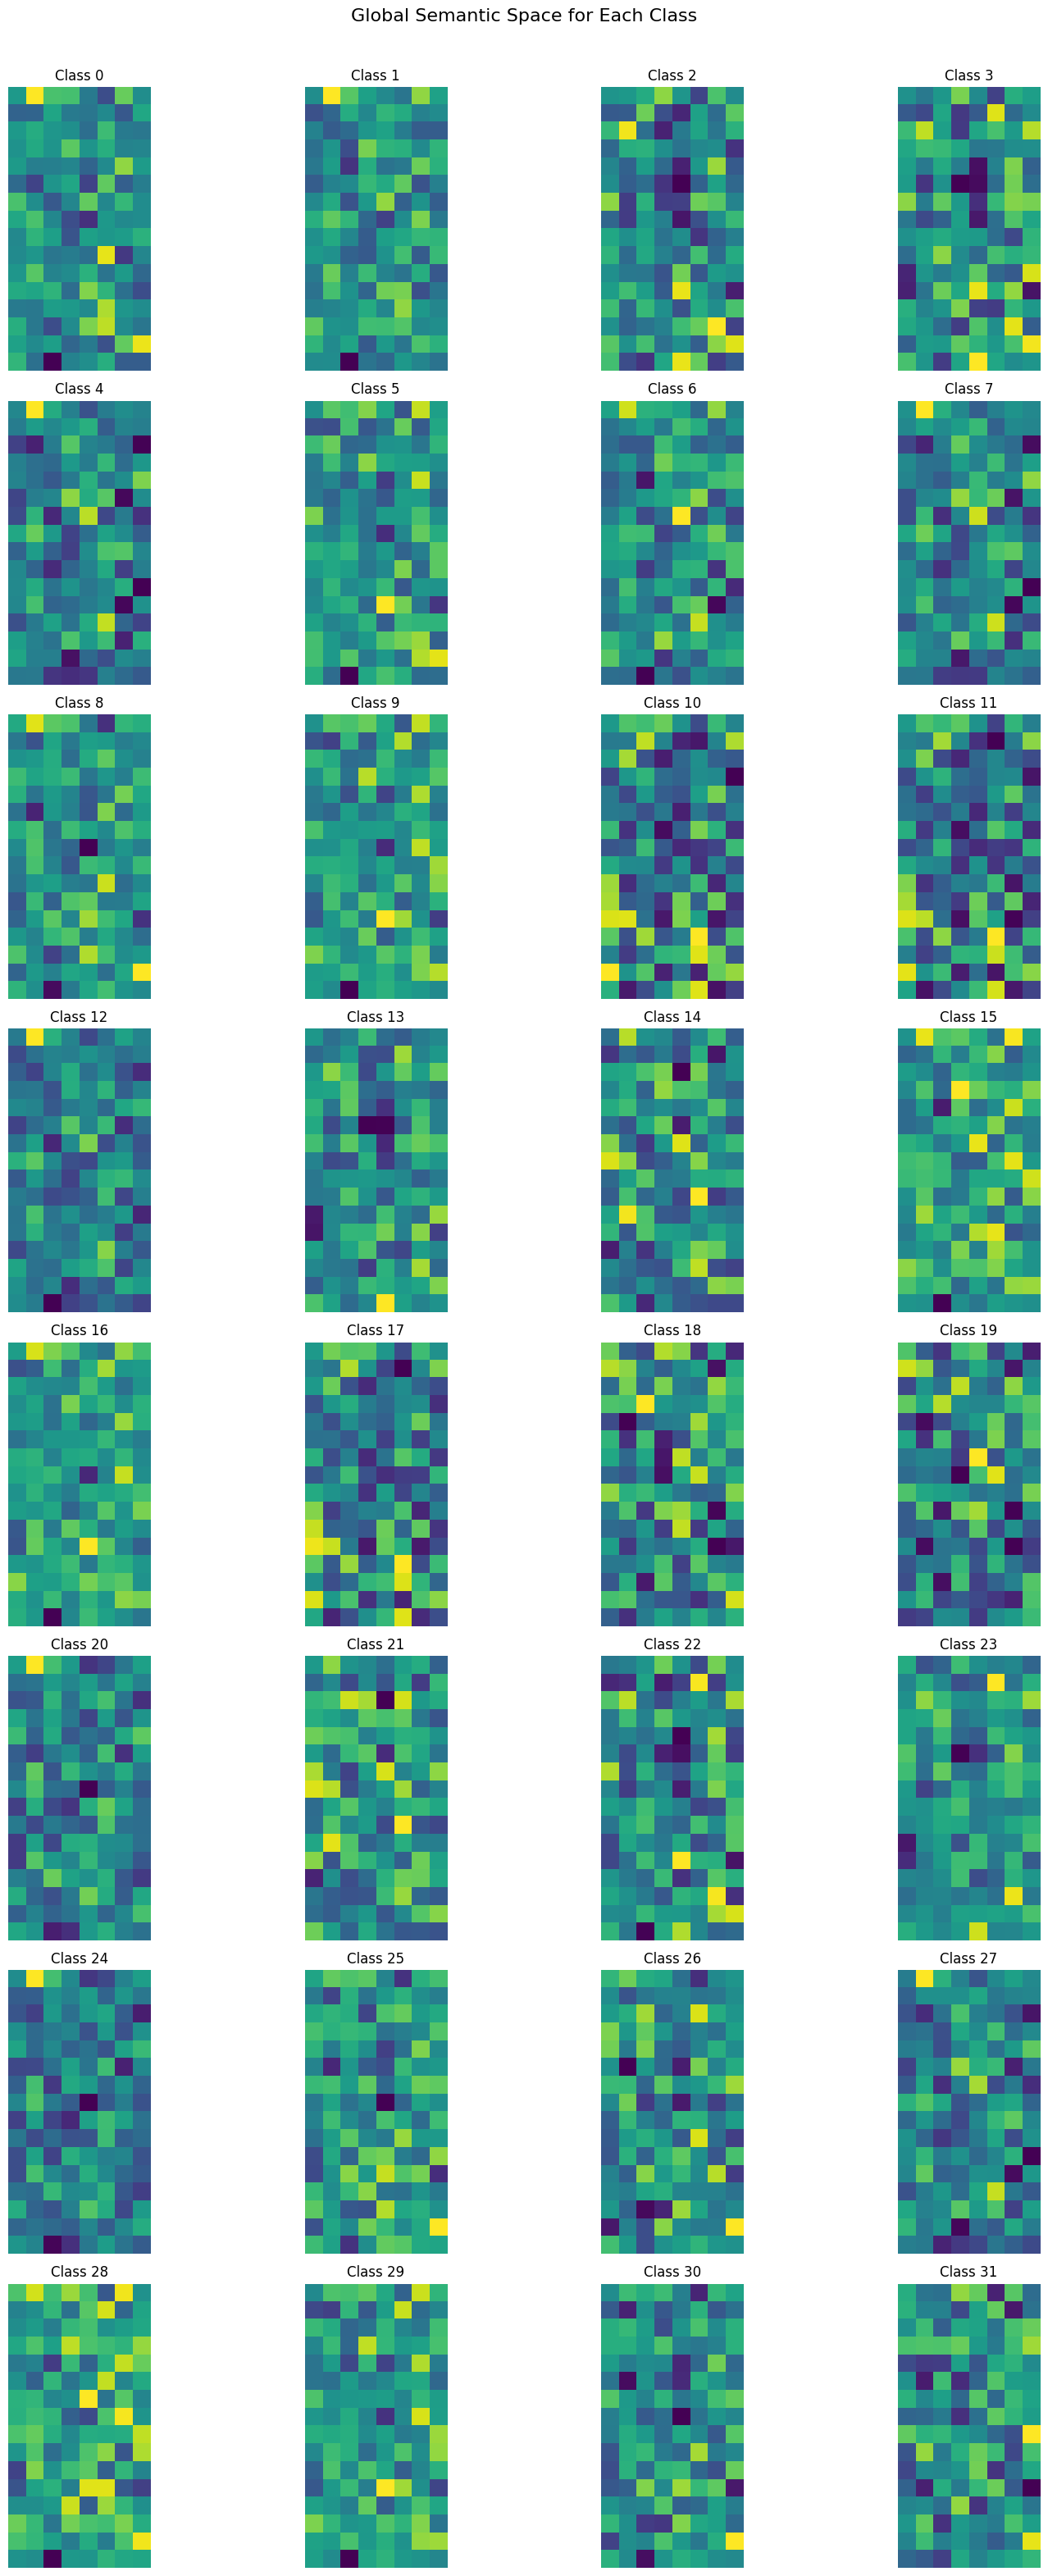

In [71]:
def visualize_global_semantic_space(global_semantic_space, num_classes=32):
    fig, axes = plt.subplots(8, 4, figsize=(16, 32))
    fig.suptitle("Global Semantic Space for Each Class", fontsize=16)
    
    global_semantic_space_normalized = F.normalize(global_semantic_space, dim=1).cpu().numpy()
    
    for class_id in range(num_classes):
        ax = axes[class_id // 4, class_id % 4]
        embedding = global_semantic_space_normalized[class_id].reshape(16, 8)  
        ax.imshow(embedding, cmap='viridis')
        ax.set_title(f"Class {class_id}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

visualize_global_semantic_space(global_semantic_space)


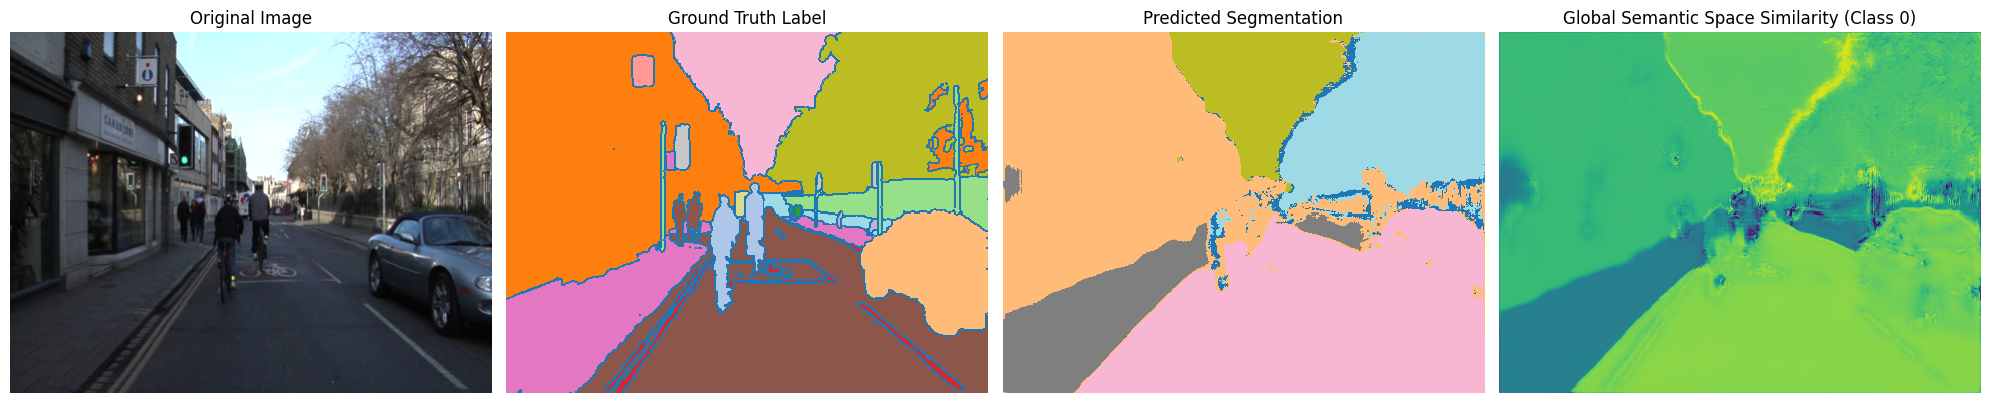

In [72]:
def visualize_predictions(images, labels, predictions, embeddings, global_semantic_space, idx=0):
    """
    Visualize the original image, ground truth label, predicted segmentation, and global semantic similarity.
    """
    fig, axes = plt.subplots(1, 4, figsize=(20, 10))
    
    # Original image
    axes[0].imshow(images[idx].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    # Ground truth label
    axes[1].imshow(labels[idx].cpu().numpy(), cmap='tab20', interpolation='none')
    axes[1].set_title("Ground Truth Label")
    axes[1].axis('off')
    
    # Predicted segmentation
    axes[2].imshow(predictions[idx].cpu().numpy(), cmap='tab20', interpolation='none')
    axes[2].set_title("Predicted Segmentation")
    axes[2].axis('off')
    
    # Global semantic space similarity (calculate similarity with each class)
    with torch.no_grad():
        embedding = embeddings[idx].permute(1, 2, 0).view(-1, embeddings.size(1))  # Flatten spatial dimensions (H*W, C)
        similarity_maps = []
        
        for class_id in range(global_semantic_space.size(0)):
            class_embedding = global_semantic_space[class_id].unsqueeze(0)  # (1, 128)
            similarity = F.cosine_similarity(embedding, class_embedding, dim=1)  # (H*W)
            similarity_maps.append(similarity.view(embeddings.size(2), embeddings.size(3)))  # Reshape to (H, W)
        
        # For visualization, let's choose the similarity with the first class (or any specific class)
        similarity_map = similarity_maps[0].cpu().numpy()  # You can visualize other classes by changing the index

    axes[3].imshow(similarity_map, cmap='viridis', interpolation='none')
    axes[3].set_title("Global Semantic Space Similarity (Class 0)")
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()


with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Extract embeddings using the model for contrastive learning
        embeddings = model(images, extract_embeddings=True)  # Ensure extract_embeddings=True for contrastive embeddings
        predictions = model(images, extract_embeddings=False)  # Perform segmentation
        
        predictions = torch.argmax(predictions, dim=1)
        
        # Visualize the results
        visualize_predictions(images, labels, predictions, embeddings, global_semantic_space, idx=0)
        break

